In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [9]:
listings = pd.read_csv('listings_cleaned.csv',index_col = 0)
pd.set_option('display.max_columns', None)
listings.head(2)

,host_is_superhost,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,zipcode_cleaned,neighbourhood_listing_total,amenities_score
0,f,t,43.64617,-79.42451,House,Entire home/apt,10,3.0,5.0,7.0,469.0,1000.0,150.0,0.0,4,730,0,0,7,100.0,f,strict_14_with_grace_period,M6,484,5.0
1,f,f,43.64105,-79.37628,Apartment,Private room,2,1.5,1.0,1.0,99.0,2651.0,NaN,0.0,180,365,0,0,169,97.0,t,strict_14_with_grace_period,M5,4241,6.0


In [10]:
listings['zipcode_cleaned'].unique()

array(['M6', 'M5', 'M4', 'M1', 'M3', 'M8', 'M2', 'M9'], dtype=object)

In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22531 entries, 0 to 23397
Data columns (total 25 columns):
host_is_superhost              22531 non-null object
host_identity_verified         22531 non-null object
latitude                       22531 non-null float64
longitude                      22531 non-null float64
property_type                  22531 non-null object
room_type                      22531 non-null object
accommodates                   22531 non-null int64
bathrooms                      22525 non-null float64
bedrooms                       22507 non-null float64
beds                           22389 non-null float64
price                          22531 non-null float64
security_deposit               22531 non-null float64
cleaning_fee                   19143 non-null float64
extra_people                   22531 non-null float64
minimum_nights                 22531 non-null int64
maximum_nights                 22531 non-null int64
availability_30                22531 

In [12]:
target = ['price']

cat_features = ['host_is_superhost', 'host_identity_verified',
               'property_type', 'room_type', 'instant_bookable', 
                'cancellation_policy', 'zipcode_cleaned' ]  

num_features = ['latitude', 'longitude', 'accommodates', 
                'bathrooms', 'bedrooms', 'beds',
                'cleaning_fee', 'extra_people', 'security_deposit', 
                'minimum_nights', 'maximum_nights', 
                'availability_30', 'availability_365',
                'number_of_reviews', 'review_scores_rating',
                'amenities_score', 'neighbourhood_listing_total']  

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(listings, test_size=0.3, random_state=100)
print('Train set:', train_set.shape)
print('Test set:', test_set.shape)

Train set: (15771, 25)
Test set: (6760, 25)


In [39]:
X_train = train_set.loc[:, train_set.columns != 'price']
y_train = train_set['price']
X_test = test_set.loc[:, test_set.columns != 'price']
y_test = test_set['price']

In [40]:
# Create a pipeline for numerical features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# Create a pipeline that only one hot encodes categorical features
full_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_features),
        ("num", num_pipeline, num_features)
    ])

In [41]:
# Create the final input arrays for modeling

X_train = full_pipeline.fit_transform(X_train)
print('Train set: ', X_train.shape)


Train set:  (15771, 47)


In [42]:
X_test = full_pipeline.transform(X_test)
print('Test set: ', X_test.shape)

Test set:  (6760, 47)


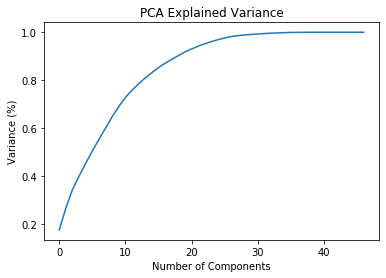

In [43]:
#Fitting the PCA algorithm with our Data
pca_g = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_g.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('PCA Explained Variance')
plt.show()

In [44]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [45]:
pca.n_components_

23

In [46]:
# Recalculate dataset using PCA model inverse transformation
X_reduced_inv = pca.inverse_transform(X_reduced)

In [47]:
# compute reconstruction loss
loss = ((X_train - X_reduced_inv) ** 2).mean()
loss

0.021363482419692305

In [48]:
# we lost about 4.78% of the variance:
1 - pca.explained_variance_ratio_.sum()

0.04784634590447212

Model Training

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from math import sqrt
from sklearn.metrics import mean_squared_error

In [51]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
def evaluate_model(model, predict, evaluate):
    predictions = model.predict(predict)
    RMSE = round(sqrt(mean_squared_error(predictions, evaluate)), 2)
    print("RMSE: " + str(RMSE)) 

In [53]:
def init_models():
    return [LinearRegression(),
            Lasso(),
            Ridge(),
            RandomForestRegressor(n_estimators=100),
            ElasticNet(),
            SVR()]


In [54]:
models = init_models()

In [60]:
for m in models:
    m.fit(X_train, y_train)
    evaluate_model(m, X_test, y_test)
    

RMSE: 204.56
RMSE: 204.9
RMSE: 204.56
RMSE: 209.15
RMSE: 205.25


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RMSE: 210.74
